In [1]:
import os
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv(f'{os.getcwd()}/data/mean_tpm.csv', index_col=0)

In [3]:
def normalize_group(group):
    scaler = StandardScaler()
    group['normalized_tpm'] = scaler.fit_transform(group[['mean_tpm']])
    return group

df['mean_tpm'] = np.log1p(df['mean_tpm'])
df = df.groupby('species').apply(normalize_group)
df['mean_tpm'] = df['normalized_tpm']
df = df.reset_index(drop=True)

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_4820/742114901.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('species').apply(normalize_group)


In [4]:
# One-hot encode species and stress_condition
enc_species = OneHotEncoder(sparse_output=False)
encoded_species = enc_species.fit_transform(df[['species']])

enc_stress = OneHotEncoder(sparse_output=False)
encoded_stress_condition = enc_stress.fit_transform(df[['stress_condition']])

# Function to one-hot encode DNA sequence
def one_hot_encode_sequence(sequence, max_length=200):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot_encoded = np.zeros((max_length, 4))
    for i, nucleotide in enumerate(sequence[:max_length]):
        if nucleotide in mapping:
            one_hot_encoded[i, mapping[nucleotide]] = 1
    return one_hot_encoded

# Apply one-hot encoding to the DNA sequences
max_length = df['upstream200'].apply(len).max()
sequences = df['upstream200'].apply(lambda seq: one_hot_encode_sequence(seq, max_length=max_length))
sequences = np.array(sequences.tolist())

# Combine species and stress_condition into a single group column
df['group'] = df['species'].astype(str) + "_" + df['stress_condition'].astype(str)

# Stratified split using GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['group']))

df_train_val = df.iloc[train_idx]
df_test = df.iloc[test_idx]

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(gss_val.split(df_train_val, groups=df_train_val['group']))

df_train = df_train_val.iloc[train_idx]
df_val = df_train_val.iloc[val_idx]

# Convert to PyTorch tensors
def prepare_tensors(df):
    sequences = df['upstream200'].apply(lambda seq: one_hot_encode_sequence(seq, max_length=max_length))
    sequences = np.array(sequences.tolist())
    species = enc_species.transform(df[['species']])
    stress = enc_stress.transform(df[['stress_condition']])
    y = df['mean_tpm'].values

    sequence_tensor = torch.tensor(sequences, dtype=torch.float32).permute(0, 2, 1)
    species_tensor = torch.tensor(species, dtype=torch.float32)
    stress_tensor = torch.tensor(stress, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    return sequence_tensor, species_tensor, stress_tensor, y_tensor

sequence_tensor_train, species_tensor_train, stress_tensor_train, y_tensor_train = prepare_tensors(df_train)
sequence_tensor_val, species_tensor_val, stress_tensor_val, y_tensor_val = prepare_tensors(df_val)
sequence_tensor_test, species_tensor_test, stress_tensor_test, y_tensor_test = prepare_tensors(df_test)

# Create datasets
train_dataset = TensorDataset(sequence_tensor_train, species_tensor_train, stress_tensor_train, y_tensor_train)
val_dataset = TensorDataset(sequence_tensor_val, species_tensor_val, stress_tensor_val, y_tensor_val)
test_dataset = TensorDataset(sequence_tensor_test, species_tensor_test, stress_tensor_test, y_tensor_test)

# Create dataloaders
batch_size = len(df) // 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class DNA_CNN(nn.Module):
    def __init__(self, num_species, num_stress_conditions, max_length=203):
        super(DNA_CNN, self).__init__()
        self.max_length = max_length
        
        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(32)
        self.batch_norm2 = nn.BatchNorm1d(64)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * (max_length // 4), 128)  # Adjusted for additional pooling
        self.fc_species = nn.Linear(num_species, 16)
        self.fc_stress = nn.Linear(num_stress_conditions, 16)
        self.fc2 = nn.Linear(128 + 16 * 2, 1)  # 128 from CNN + 16 from species + 16 from stress

    def forward(self, x, species, stress):
        x = self.pool(torch.relu(self.batch_norm1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.batch_norm2(self.conv2(x))))
        x = self.dropout(x)
        
        x = x.view(-1, 64 * (self.max_length // 4))  # Adjusted for additional pooling
        x = torch.relu(self.fc1(x))
        
        species = torch.relu(self.fc_species(species))
        stress = torch.relu(self.fc_stress(stress))
        
        x = torch.cat((x, species, stress), dim=1)
        x = self.fc2(x)
        return x


In [6]:
num_species = encoded_species.shape[1]
num_stress_conditions = encoded_stress_condition.shape[1]

model = DNA_CNN(num_species, num_stress_conditions, max_length=max_length)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for step, (seqs, species, stress, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(seqs, species, stress)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        step_loss = loss.item() * seqs.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{step + 1}/{len(train_loader)}], Loss: {step_loss:.4f}')
        train_loss += step_loss
    
    train_loss /= len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for seqs, species, stress, targets in val_loader:
            outputs = model(seqs, species, stress)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * seqs.size(0)

    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch [1/10], Step [1/10], Loss: 58739.3981
Epoch [1/10], Step [2/10], Loss: 364688.2023
Epoch [1/10], Step [3/10], Loss: 115419.1252
Epoch [1/10], Step [4/10], Loss: 56175.4452
Epoch [1/10], Step [5/10], Loss: 56463.9624
Epoch [1/10], Step [6/10], Loss: 56220.2137
Epoch [1/10], Step [7/10], Loss: 56276.5253
Epoch [1/10], Step [8/10], Loss: 56620.8806
Epoch [1/10], Step [9/10], Loss: 56519.9136
Epoch [1/10], Step [10/10], Loss: 26760.4142
Epoch [1/10], Train Loss: 1.3572, Validation Loss: 0.7909
Epoch [2/10], Step [1/10], Loss: 56365.1993
Epoch [2/10], Step [2/10], Loss: 56299.5234
Epoch [2/10], Step [3/10], Loss: 56349.1144
Epoch [2/10], Step [4/10], Loss: 56199.5997
Epoch [2/10], Step [5/10], Loss: 56340.2571
Epoch [2/10], Step [6/10], Loss: 56584.9443
Epoch [2/10], Step [7/10], Loss: 56327.2015
Epoch [2/10], Step [8/10], Loss: 56382.3525
Epoch [2/10], Step [9/10], Loss: 56485.3600
Epoch [2/10], Step [10/10], Loss: 26707.8325
Epoch [2/10], Train Loss: 0.8019, Validation Loss: 0.7907


In [8]:
# Evaluation on test set
model.eval()
test_loss = 0.0
predictions, ground_truth = [], []
with torch.no_grad():
    for seqs, species, stress, targets in test_loader:
        outputs = model(seqs, species, stress)
        predictions.append(outputs)
        ground_truth.append(targets)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * seqs.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.7892


In [9]:
predictions = torch.cat(predictions, axis=0)
ground_truth = torch.cat(ground_truth, axis=0)
output_df = pd.DataFrame({'actual': ground_truth.flatten(), 'predicted': predictions.flatten()})

In [10]:
predictions

tensor([[0.0245],
        [0.0245],
        [0.0245],
        ...,
        [0.0281],
        [0.0210],
        [0.0295]])

In [11]:
ground_truth

tensor([[-1.5885],
        [ 0.7571],
        [-1.5885],
        ...,
        [ 0.7212],
        [ 0.8883],
        [ 0.5923]])

### Scatter Plot

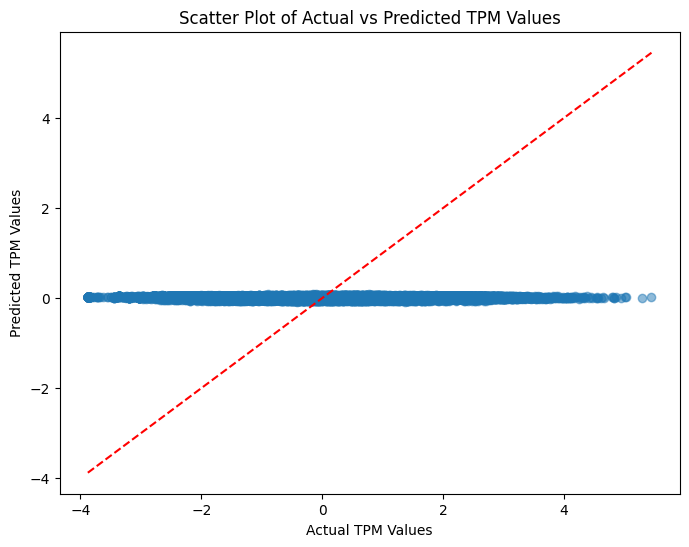

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(output_df['actual'], output_df['predicted'], alpha=0.5)
plt.plot([output_df['actual'].min(), output_df['actual'].max()], [output_df['actual'].min(), output_df['actual'].max()], 'r--')
plt.xlabel('Actual TPM Values')
plt.ylabel('Predicted TPM Values')
plt.title('Scatter Plot of Actual vs Predicted TPM Values')
plt.show()

### Residual Plot

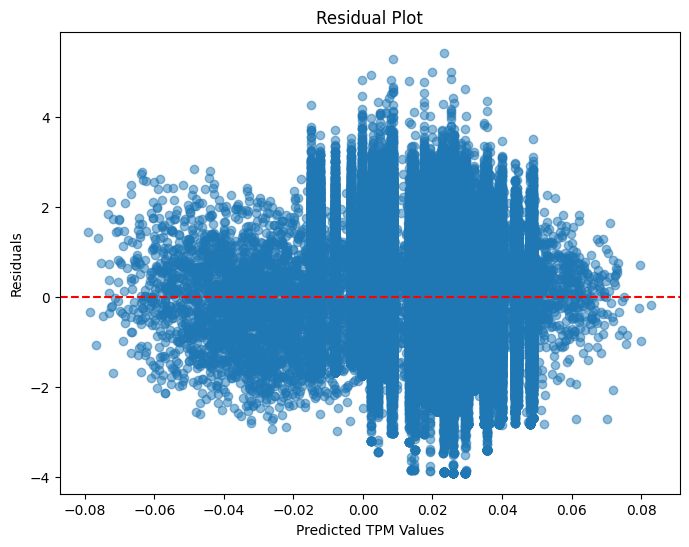

In [13]:
output_df['residuals'] = output_df['actual'] - output_df['predicted']

plt.figure(figsize=(8, 6))
plt.scatter(output_df['predicted'], output_df['residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted TPM Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Distribution Plot

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_4820/1897310507.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.expm1(output_df['actual']), label='Actual', shade=True)
/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_4820/1897310507.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.expm1(output_df['predicted']), label='Predicted', shade=True)


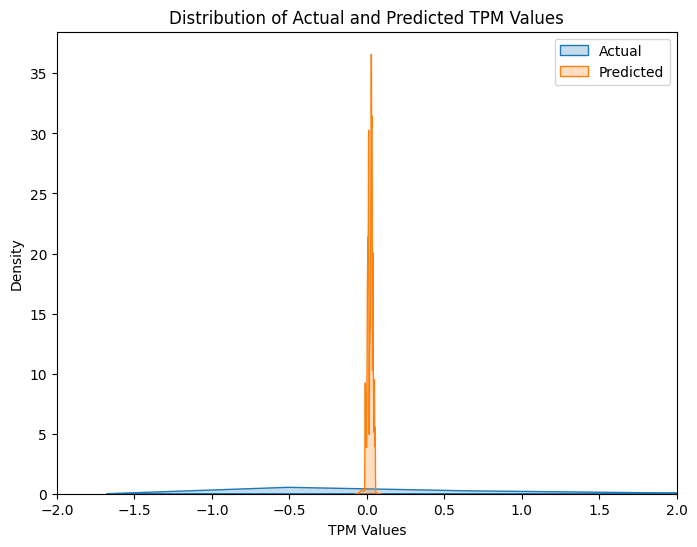

In [23]:
plt.figure(figsize=(8, 6))
sns.kdeplot(np.expm1(output_df['actual']), label='Actual', shade=True)
sns.kdeplot(np.expm1(output_df['predicted']), label='Predicted', shade=True)
#boundary for x 
plt.xlim(-2, 2)
plt.xlabel('TPM Values')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted TPM Values')
plt.legend()
plt.show()

### Box Plot

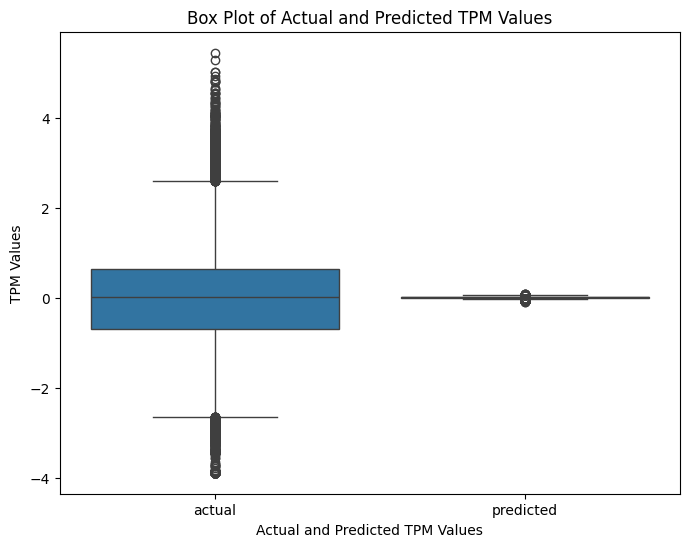

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=output_df[['actual', 'predicted']])
plt.xlabel('Actual and Predicted TPM Values')
plt.ylabel('TPM Values')
plt.title('Box Plot of Actual and Predicted TPM Values')
plt.show()

### Parity Plot

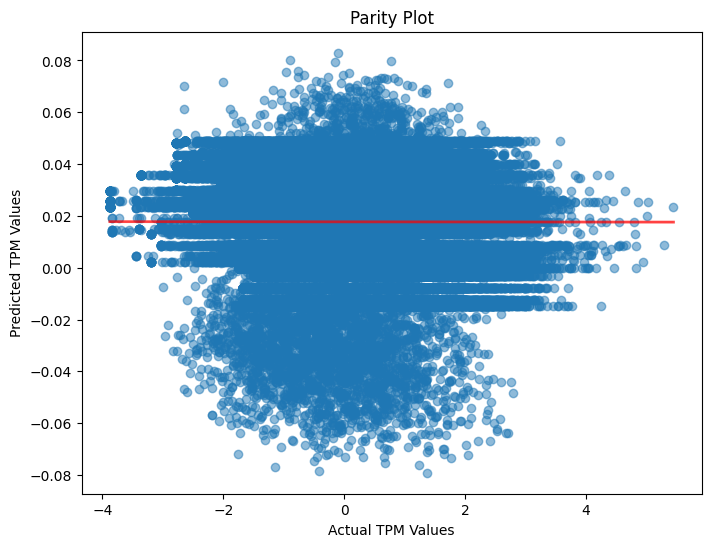

In [16]:
plt.figure(figsize=(8, 6))
sns.regplot(x='actual', y='predicted', data=output_df, scatter_kws={'alpha':0.5}, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.xlabel('Actual TPM Values')
plt.ylabel('Predicted TPM Values')
plt.title('Parity Plot')
plt.show()

### Cumulative Density Function (CDF) Plot

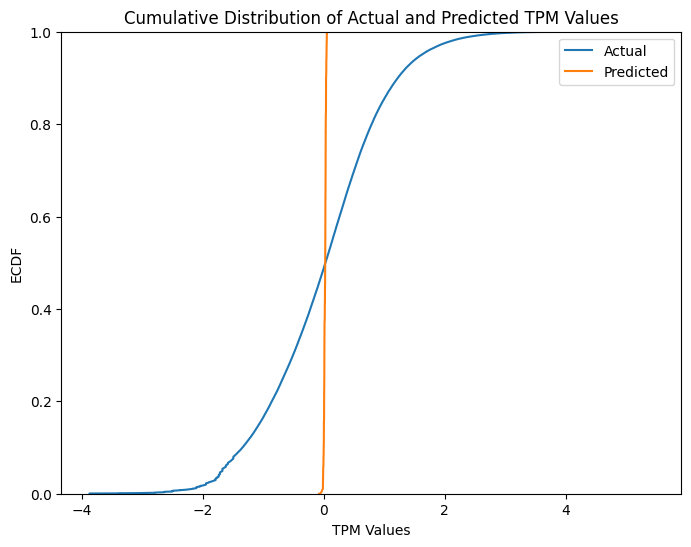

In [17]:
plt.figure(figsize=(8, 6))
sns.ecdfplot(output_df['actual'], label='Actual')
sns.ecdfplot(output_df['predicted'], label='Predicted')
plt.xlabel('TPM Values')
plt.ylabel('ECDF')
plt.title('Cumulative Distribution of Actual and Predicted TPM Values')
plt.legend()
plt.show()